# 모듈 불러오기

In [5]:
import os
import json
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 시각화 함수

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string],'')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 파일 로드

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

# 렌덤 시드 고정

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [14]:
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE,'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE,'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 모델 하이퍼파라미터 정의

In [15]:
model_name = 'malstm_similarity'
BATCH_SIZE = 125
NUM_EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_dimension': 100,
    'lstm_dimension': 150
}

# 모델 선언 및 컴파일

In [17]:
class MaLSTM(tf.keras.Model):
    def __init__(self, **kargs):
        super(MaLSTM, self).__init__(name=model_name)
        self.embedding = layers.Embedding(input_dim = kargs['vocab_size'],
                                          output_dim=kargs['embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])

    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)
        # 멘하탄 모델을 사용하는 부분 (수식을 코드로 나타냄)
        x = tf.exp(-tf.reduce_sum(tf.abs(x1-x2), axis=1))

        return x



In [26]:
model = MaLSTM(**kargs)

model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
model.summary()

# Callback 선언

In [23]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out -- Folder already exists 



# 모델 학습

In [27]:
history = model.fit((q1_data, q2_data), labels, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split= VALID_SPLIT, callbacks = [earlystop_callback, cp_callback])

Epoch 1/5
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6756 - loss: 0.6164
Epoch 1: val_accuracy improved from -inf to 0.73042, saving model to ./data_out/malstm_similarity.weights.h5
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 214s 99ms/step - accuracy: 0.6756 - loss: 0.6163 - val_accuracy: 0.7304 - val_loss: 0.5648
Epoch 2/5
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8041 - loss: 0.4288
Epoch 2: val_accuracy improved from 0.73042 to 0.79560, saving model to ./data_out/malstm_similarity.weights.h5
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 213s 99ms/step - accuracy: 0.8041 - loss: 0.4288 - val_accuracy: 0.7956 - val_loss: 0.4872
Epoch 3/5
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8358 - loss: 0.3727
Epoch 3: val_accuracy improved from 0.79560 to 0.83671, saving model to ./data_out/malstm_similarity.weights.h5
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 213s 99ms/step - accuracy: 0.8358 - loss: 0.3727 - val_accuracy: 0.8367 - val_loss: 0.4481
Epoch 4/5
2150/2150 ━━━━━━━━━━━━━━━━━

# 결과 플롯

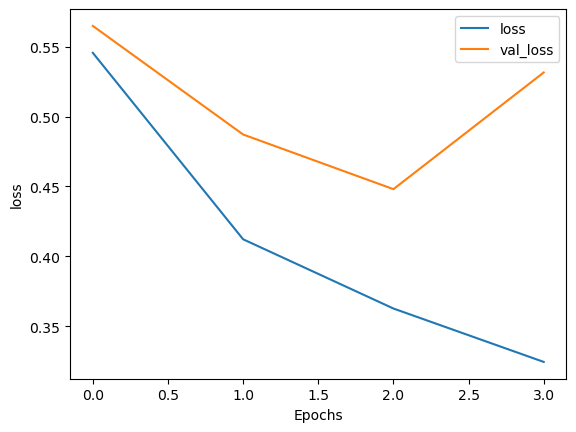

In [29]:
plot_graphs(history, 'loss')

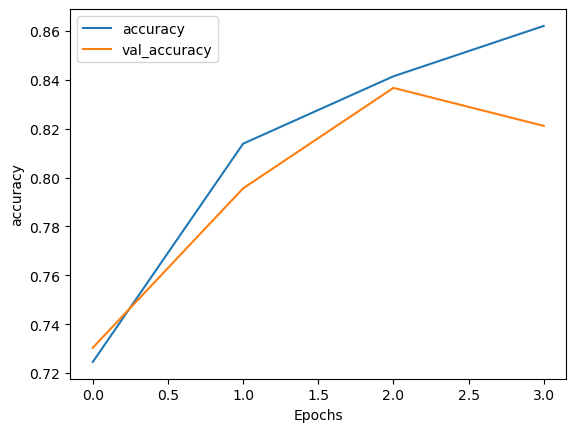

In [30]:
plot_graphs(history, 'accuracy')

# 테스트 데이터 불러오기

In [31]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

# 베스트 모델 불러오기

In [33]:
model.load_weights(os.path.join('./data_out/malstm_similarity.weights.h5'))

# 베스트 데이터 예측하기

In [34]:
prediction = model.predict((test_q1_data, test_q2_data), batch_size = BATCH_SIZE)

18767/18767 ━━━━━━━━━━━━━━━━━━━━ 549s 29ms/step


In [36]:
ouput = pd.DataFrame(data= {'test_id': test_id_data, 'is_duplicate':list(prediction)})
ouput.to_csv(DATA_OUT_PATH+'rnn_predict.csv', index=False, quoting=3)